In [1]:
'''
Create an image with one box in the middle of the image
Create a noise image with the same size as the image
Calculate the PSNR, from our metric, between the denoised image and the noise image
'''

'\nCreate an image with one box in the middle of the image\nCreate a noise image with the same size as the image\nCalculate the PSNR, from our metric, between the denoised image and the noise image\n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def create_box_image(height=512, width=512, box_size=50, background=0, box_value=1):
    """
    Create a test image with a box in the middle and return its bbox coordinates.
    
    Args:
        height (int): Image height
        width (int): Image width
        box_size (int): Size of the box (square)
        background (float): Background pixel value
        box_value (float): Box pixel value
    
    Returns:
        tuple: (image, bbox)
            - image (np.ndarray): Image with a box in the middle
            - bbox (dict): Dictionary containing box coordinates:
                - x1, y1: top-left corner
                - x2, y2: bottom-right corner
                - center_x, center_y: center coordinates
                - width, height: box dimensions
    """
    # Create empty image
    image = np.full((height, width), background, dtype=np.float32)
    
    # Calculate box coordinates
    y_start = height//2 - box_size//2
    y_end = y_start + box_size
    x_start = width//2 - box_size//2
    x_end = x_start + box_size
    
    # Add box
    image[y_start:y_end, x_start:x_end] = box_value
    
    # Create bbox dictionary
    bboxes = [{
        'x1': x_start,
        'y1': y_start,
        'x2': x_end,
        'y2': y_end,
        'center_x': width//2,
        'center_y': height//2,
        'width': box_size,
        'height': box_size
    }]
    
    return image, bboxes

In [3]:
# Create and display the image
clean_image, bboxes = create_box_image()
noisy_image = clean_image + np.random.normal(0, 0.1, clean_image.shape)

# scale the images to 0-255
clean_image = (clean_image * 255).astype(np.uint8)
# min-max scale the noisy image
noisy_image = (noisy_image - noisy_image.min()) / (noisy_image.max() - noisy_image.min()) * 255
noisy_image = noisy_image.astype(np.uint8)


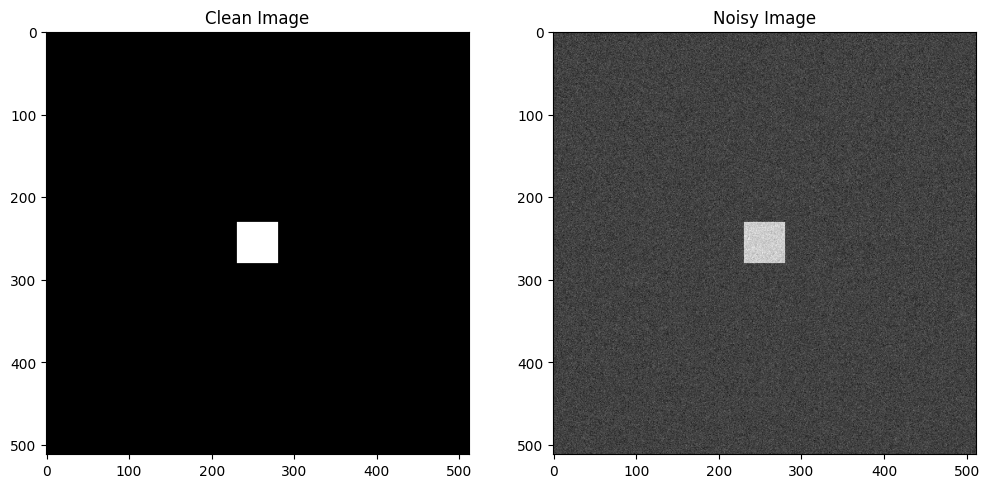

In [4]:
# show the images side by side
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Clean Image")
plt.imshow(clean_image, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Noisy Image")
plt.imshow(noisy_image, cmap="gray")
plt.show()

In [5]:
# Convert bboxes to list of tuples (x1, y1, w, h)
for bbox in bboxes:
    print(bbox)

bboxes = [[bbox['x1'], bbox['y1'], bbox['width'], bbox['height']] for bbox in bboxes]


{'x1': 231, 'y1': 231, 'x2': 281, 'y2': 281, 'center_x': 256, 'center_y': 256, 'width': 50, 'height': 50}


In [6]:
print(bboxes)

[[231, 231, 50, 50]]


In [7]:
# save clean image to file
import cv2
from psnr import PSNR_classical

cv2.imwrite('clean_image.png', clean_image)
cv2.imwrite('noisy_image.png', noisy_image)

psnr_classical_clean = PSNR_classical('clean_image.png', bboxes, 'test', 0)
psnr_classical_noisy = PSNR_classical('noisy_image.png', bboxes, 'test', 0)

print(f'BW Noisy image psnr: {psnr_classical_noisy.calculate_psnr_image_vs_bw()}')
print(f'BW Clean image psnr: {psnr_classical_clean.calculate_psnr_image_vs_bw()}')




(512, 512)
Noisy image psnr: 11.604945563377294
(512, 512)
Clean image psnr: 313.07119549054045


In [28]:
from psnr import PSNR
snr_ratio_obj = PSNR(noisy_image, clean_image, bboxes, 'test', 0)
ratio = snr_ratio_obj.ratio()
print(ratio)

99.98341903980699


<Figure size 640x480 with 0 Axes>

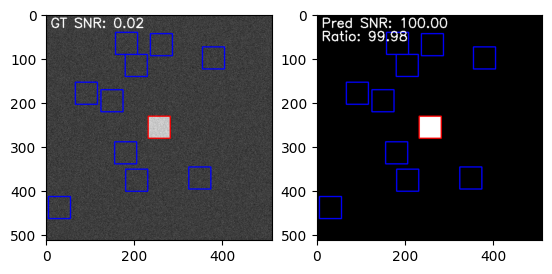

In [29]:
import cv2

gt_anno = (snr_ratio_obj.gt_img.copy()).astype(np.uint8)
pred_anno = (snr_ratio_obj.pred_img.copy()).astype(np.uint8)
gt_anno = cv2.cvtColor(gt_anno, cv2.COLOR_GRAY2RGB)
pred_anno = cv2.cvtColor(pred_anno, cv2.COLOR_GRAY2RGB)
random_locations = snr_ratio_obj.random_locations_list[0]
first_bbox_noise_crops = snr_ratio_obj.gt_noise_crops_list[0]
x1, y1, w, h = snr_ratio_obj.bboxes[0]
gt_anno = cv2.rectangle(gt_anno, (int(x1), int(y1)), (int(x1+w), int(y1+h)), (255, 0, 0), 2)
pred_anno = cv2.rectangle(pred_anno, (int(x1), int(y1)), (int(x1+w), int(y1+h)), (255, 0, 0), 2)
for y, x in random_locations:
    gt_anno = cv2.rectangle(gt_anno, (int(x), int(y)), (int(x+first_bbox_noise_crops[0].shape[1]), int(y+first_bbox_noise_crops[0].shape[0])), (0, 0, 255), 2)
    pred_anno = cv2.rectangle(pred_anno, (int(x), int(y)), (int(x+first_bbox_noise_crops[0].shape[1]), int(y+first_bbox_noise_crops[0].shape[0])), (0, 0, 255), 2)
# Write SNR and ratio to the image
gt_snr_avg_str = f"GT SNR: {snr_ratio_obj.gt_snr_avg:.2f}"
pred_snr_avg_str = f"Pred SNR: {snr_ratio_obj.pred_snr_avg:.2f}"
ratio_str = f"Ratio: {snr_ratio_obj.psnr_ratio:.2f}"
gt_anno = cv2.putText(gt_anno, gt_snr_avg_str, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
pred_anno = cv2.putText(pred_anno, pred_snr_avg_str, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
pred_anno = cv2.putText(pred_anno, ratio_str, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
import matplotlib.pyplot as plt
plt.clf()
fig, ax = plt.subplots(1, 2)
ax[0].imshow(gt_anno, cmap='gray')
ax[1].imshow(pred_anno, cmap='gray')
plt.show()
plt.close()


In [ ]:
import numpy as np
from scipy.stats import skew, kurtosis
import random
import matplotlib.pyplot as plt

def bimodality_coefficient(data):
  """
  Calculates Sarle's bimodality coefficient for a given dataset.

  Args:
    data: A 1D numpy array or list of numerical data.

  Returns:
    The bimodality coefficient (float) or None if the calculation is not possible.
  """
  # Ensure data is a numpy array
  data = np.array(data)

  # Handle edge cases where calculation is not possible
  if len(data) < 4 or np.std(data) == 0:
    return None

  # Calculate skewness and kurtosis
  s = skew(data)
  k = kurtosis(data)

  # Calculate the bimodality coefficient
  b = (s**2 + 1) / (k + (3*(len(data)-1)**2)/((len(data)-2)*(len(data)-3)))

  return b

data1 = np.random.rand(32,32)
data2 = np.random.rand(32, 32)
data1 = np.where(np.random.rand(32, 32)>0.5, data1**0.1, (1 - data1** 0.1))

bc1 = bimodality_coefficient(data1.flatten())
bc2 = bimodality_coefficient(data2.flatten())

print(f"Bimodality coefficient for data1: {bc1}")
print(f"Bimodality coefficient for data2: {bc2}")

fig, ax = plt.subplots(2,2)
ax[0,0].imshow(data1)
ax[0,1].imshow(data2)
ax[1, 0].hist(data1)
ax[1, 1].hist(data2)
plt.show()